In [36]:
import numpy as np
#from bgen_reader import open_bgen
#from os.path import join
#from pandas_plink import read_plink1_bin
#from pandas_plink import get_data_folder
import matplotlib.pyplot as plt
#from bgen_reader import open_bgen
#from bed_reader import open_bed, sample_file
import pandas as pd
# import os
from pysnptools.distreader import Bgen, DistMemMap
from pathlib import Path
import numpy as np
from bed_reader import open_bed
from pysnptools.snpreader import SnpData, SnpMemMap
from pysnptools.util import log_in_place
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from KDEpy import FFTKDE
# from pybgen import PyBGEN
import multiprocessing as mp

NameError: name 'numba' is not defined

In [37]:
import multiprocessing as mp

In [34]:
def MI_continuous(a, b, a_min, a_max, N=500):
    """
    calculate mutual information between continuous outcome and an SNP variable of 0,1,2
    assume no missing data
    """
    # first estimate the pmf
    p0 = np.sum(b==0)/len(b)
    p1 = np.sum(b==1)/len(b)
    p2 = 1.-p0-p1
    # estimate cond density
    _b0 = (b==0)
    if np.sum(_b0)>2: # here proceed to kde only if there are more than 5 data points
        y_cond_p0 = FFTKDE(kernel="gaussian", bw="silverman").fit(data=a[_b0])
#         y_cond_p0 = gaussian_kde(a[_b0])
    else:
        y_cond_p0 = np.zeros_like
    _b1 = (b==1)
    if np.sum(_b1)>2:
        y_cond_p1 = FFTKDE(kernel="gaussian", bw="silverman").fit(data=a[_b1])
#         y_cond_p1 = gaussian_kde(a[_b1]) # this thing uses Scott's rule instead of Silverman defaulted by FFTKDE and R density
    else:
        y_cond_p1 = np.zeros_like
    _b2 = (b==2)
    if np.sum(_b2)>2:
        y_cond_p2 = FFTKDE(kernel="gaussian", bw="silverman").fit(data=a[_b2])
#         y_cond_p2 = gaussian_kde(a[_b2])
    else:
        y_cond_p2 = np.zeros_like
    joint = np.empty((N,3))
    a_temp = np.linspace(a_min, a_max, num=N)
    joint[:,0] = y_cond_p0(a_temp)*p0
    joint[:,1] = y_cond_p1(a_temp)*p1
    joint[:,2] = y_cond_p2(a_temp)*p2
    joint[joint<1e-20] = 1e-20 # set a threshold to avoid numerical errors
    forward_euler_step = a_temp[1]-a_temp[0]
#     print("total measure:", np.sum(joint)*forward_euler_step)
    temp_log = np.log(joint)
#     temp_log = np.nan_to_num(temp_log, nan = 0)
    temp1 = np.log(np.sum(joint, 1))
#     temp1 = np.nan_to_num(temp1, nan = 0)
    temp_log = temp_log - temp1.reshape(-1,1)
    temp2 = np.log(np.sum(joint, 0)*forward_euler_step)
#     temp2 = np.nan_to_num(temp2, nan = 0)
    temp_log = temp_log - temp2.reshape(1,-1)
    # print(fhat_mat * temp_log)
    temp_mat = joint * temp_log
#     temp_mat = np.nan_to_num(temp_mat, nan=0.) # numerical fix
    mi_temp = np.sum(temp_mat)*forward_euler_step
    return mi_temp

def MI_binary(a, b, a_min, a_max, N=500):
    """
    calculate mutual information between binary outcome and an SNP variable of 0,1,2
    assume no missing data
    """
    # first estimate the pmf of SNP
    p0 = np.sum(b==0)/len(b)
    p1 = np.sum(b==1)/len(b)
    p2 = 1.-p0-p1
    # estimate pmf of the binary outcome
    a_p0 = np.sum(a==0)/len(a)
    a_p1 = np.sum(a==1)/len(a)
    # estimate cond density
    _b0 = (b==0)
    if np.sum(_b0)>2: # here proceed to kde only if there are more than 5 data points
        y_cond_p0 = lambda x: x*np.sum(a[_b0]==1)/len(a[_b0]) + (1-x)*np.sum(a[_b0]==0)/len(a[_b0])
#         y_cond_p0 = gaussian_kde(a[_b0])
    else:
        y_cond_p0 = np.zeros_like
    _b1 = (b==1)
    if np.sum(_b1)>2:
        y_cond_p1 = lambda x: x*np.sum(a[_b1]==1)/len(a[_b1]) + (1-x)*np.sum(a[_b1]==0)/len(a[_b1])
#         y_cond_p1 = gaussian_kde(a[_b1]) # this thing uses Scott's rule instead of Silverman defaulted by FFTKDE and R density
    else:
        y_cond_p1 = np.zeros_like
    _b2 = (b==2)
    if np.sum(_b2)>2:
        y_cond_p2 = lambda x: x*np.sum(a[_b2]==1)/len(a[_b2]) + (1-x)*np.sum(a[_b2]==0)/len(a[_b2])
#         y_cond_p2 = gaussian_kde(a[_b2])
    else:
        y_cond_p2 = np.zeros_like
    joint = np.empty((N,3))
    a_temp = np.linspace(a_min, a_max, num=N)
    joint[:,0] = y_cond_p0(a_temp)*p0
    joint[:,1] = y_cond_p1(a_temp)*p1
    joint[:,2] = y_cond_p2(a_temp)*p2
    joint[joint<1e-20] = 1e-20 # set a threshold to avoid numerical errors
    forward_euler_step = a_temp[1]-a_temp[0]
#     print("total measure:", np.sum(joint)*forward_euler_step)
    temp_log = np.log(joint)
#     temp_log = np.nan_to_num(temp_log, nan = 0)
    temp1 = np.log(np.sum(joint, 1))
#     temp1 = np.nan_to_num(temp1, nan = 0)
    temp_log = temp_log - temp1.reshape(-1,1)
    temp2 = np.log(np.sum(joint, 0)*forward_euler_step)
#     temp2 = np.nan_to_num(temp2, nan = 0)
    temp_log = temp_log - temp2.reshape(1,-1)
    # print(fhat_mat * temp_log)
    temp_mat = joint * temp_log
#     temp_mat = np.nan_to_num(temp_mat, nan=0.) # numerical fix
    mi_temp = np.sum(temp_mat)*forward_euler_step
    return mi_temp


def continuous_filter(bed_file, bim_file, fam_file, outcome, percentile, a_min=100., a_max=250., N=500):
    bed1 = open_bed(bed_file,fam_filepath=fam_file, bim_filepath=bim_file)
    gene_iid = np.array(list(bed1.iid))
    bed1_sid = np.array(list(bed1.sid))
    MI_UKBB = np.zeros_like(bed1_sid)
    for j in range(len(MI_UKBB)):
        _SNP = bed1.read(np.s_[:,j],dtype=np.int8).flatten()
        _SNP = _SNP[np.intersect1d(gene_iid, outcome_iid, assume_unique=True, return_indices=True)[1]] # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127] # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127] # remove missing SNP
        MI_UKBB[j] = MI_continuous(a=outcome, b=_SNP, a_min = a_min, a_max = a_max, N=N)
    _percentile = np.percentile(MI_UKBB, percentile)
    return bed1_sid[MI_UKBB > _percentile]

def binary_filter(bed_file, bim_file, fam_file, outcome, percentile, prop=.1, a_min=100., a_max=250., N=500):
    bed1 = open_bed(bed_file,fam_filepath=fam_file, bim_filepath=bim_file)
    gene_iid = np.array(list(bed1.iid))
    bed1_sid = np.array(list(bed1.sid))
    MI_UKBB = np.zeros_like(bed1_sid)
    for j in range(len(MI_UKBB)):
        _SNP = bed1.read(np.s_[:,j],dtype=np.int8).flatten()
        _SNP = _SNP[np.intersect1d(gene_iid, outcome_iid, assume_unique=True, return_indices=True)[1]] # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127] # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127] # remove missing SNP
        MI_UKBB[j] = MI_binary(a=outcome, b=_SNP, a_min = a_min, a_max = a_max, N=N)
    _percentile = np.percentile(MI_UKBB, percentile)
    return bed1_sid[MI_UKBB > _percentile]


def continuous_filter_parallel(bed_file, bim_file, fam_file, outcome, percentile, a_min=100., a_max=250., N=500, chunck_size=60000):
    bed1 = open_bed(bed_file,fam_filepath=fam_file, bim_filepath=bim_file)
    gene_iid = np.array(list(bed1.iid))
    bed1_sid = np.array(list(bed1.sid))
    def _continuous_filter_slice(_slice):
        _MI_slice = np.zeros_like(_slice)
        k = 0
        for j in _slice:
            _SNP = bed1.read(np.s_[:,j],dtype=np.int8).flatten()
            _SNP = _SNP[np.intersect1d(gene_iid, outcome_iid, assume_unique=True, return_indices=True)[1]] # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127] # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127] # remove missing SNP
            _MI_slice[k] = MI_continuous(a=outcome, b=_SNP, a_min = a_min, a_max = a_max, N=N)
            k += 1
        return _MI_slice
    # multiprocessing starts here
    ind = np.arange(len(gene_iid))
    n_slices = np.floor(len(gene_iid)/chunck_size)
    with mp.Pool(mp.cpu_count()) as p:
        MI_UKBB = p.map(_continuous_filter_slice, np.array_split(ind, n_slices))
    MI_UKBB = np.hstack(MI_UKBB)
    _percentile = np.percentile(MI_UKBB, percentile)
    return bed1_sid[MI_UKBB > _percentile]


def binary_filter_parallel(bed_file, bim_file, fam_file, outcome, percentile, a_min=100., a_max=250., N=500, chunck_size=60000):
    bed1 = open_bed(bed_file,fam_filepath=fam_file, bim_filepath=bim_file)
    gene_iid = np.array(list(bed1.iid))
    bed1_sid = np.array(list(bed1.sid))
    def _binary_filter_slice(_slice):
        _MI_slice = np.zeros_like(_slice)
        k = 0
        for j in _slice:
            _SNP = bed1.read(np.s_[:,j],dtype=np.int8).flatten()
            _SNP = _SNP[np.intersect1d(gene_iid, outcome_iid, assume_unique=True, return_indices=True)[1]] # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127] # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127] # remove missing SNP
            _MI_slice[k] = MI_binary(a=outcome, b=_SNP, a_min = a_min, a_max = a_max, N=N)
            k += 1
        return _MI_slice
    # multiprocessing starts here
    ind = np.arange(len(gene_iid))
    n_slices = np.floor(len(gene_iid)/chunck_size)
    with mp.Pool(mp.cpu_count()) as p:
        MI_UKBB = p.map(_binary_filter_slice, np.array_split(ind, n_slices))
    MI_UKBB = np.hstack(MI_UKBB)
    _percentile = np.percentile(MI_UKBB, percentile)
    return bed1_sid[MI_UKBB > _percentile]



In [3]:
a = np.random.binomial(2,.3, 200)
b = np.random.binomial(2,.3, 200)
print(MI_binary(a, b, a_min=0., a_max=2., N=500))


0.2096182966772172

In [4]:
bed_file = r"/home/kyang/UKBB/genetics/cal/ukb_cal_chr20_v2.bed"
bim_file = r"/home/kyang/UKBB/genetics/cal/ukb_snp_chr20_v2.bim"
fam_file = r"/home/kyang/UKBB/genetics/cal/ukb45551_cal_chr20_v2_s488264.fam"
# bed_file = r"/home/kyang/scratch/merged.bed"
# bim_file = r"/home/kyang/scratch/merged.bim"
# fam_file = r"/home/kyang/scratch/merged.fam"
outcome_file = r"/home/kyang/UKBB/tabular/archive/40663/ukb40663.csv"
fields = ["eid", "50-0.0"]
bed1 = open_bed(bed_file,fam_filepath=fam_file, bim_filepath=bim_file)

gene_iid = np.array(list(bed1.iid))
bed1_sid = np.array(list(bed1.sid))
bed1_val = bed1.read(np.s_[:,0],dtype=np.int8)
print(bed1_val)
print(gene_iid)
print(len(bed1_sid))

[[2]
 [2]
 [2]
 ...
 [2]
 [2]
 [2]]
['5983776' '2037422' '5850468' ... '5696481' '5379448' '2921868']
19959


['1000011' '1000026' '1000032' ... '6025082' '6025094' '6025103']
['1000011' '1000026' '1000032' ... '6025082' '6025094' '6025103']
[164. 158. 166. ... 159. 152. 158.]
[   2    2 -127 ...    2    2    2]


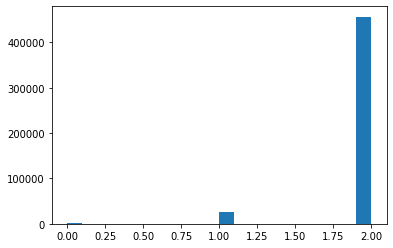

In [5]:
# read in outcome data while dropping the missing data
height = pd.read_csv(outcome_file, skipinitialspace=True, usecols=fields, encoding= 'unicode_escape').dropna()
outcome_iid = list(height.loc[:,"eid"])
outcome_iid = np.array(list(map(str, outcome_iid)))
outcome_iid
# this can get sorted intersecting SNP data
print(gene_iid[np.intersect1d(gene_iid, outcome_iid, assume_unique=True, return_indices=True)[1]])

# this can get sorted intersecting outcome data
print(outcome_iid[np.intersect1d(outcome_iid, gene_iid, assume_unique=True, return_indices=True)[1]])
_outcome = np.array(list(height.loc[:,"50-0.0"]))
_outcome = _outcome[np.intersect1d(outcome_iid, gene_iid, assume_unique=True, return_indices=True)[1]]
print(_outcome)
_SNP = bed1.read(np.s_[:,0],dtype=np.int8).flatten() # 0 is the the index
_SNP = _SNP[np.intersect1d(gene_iid, outcome_iid, assume_unique=True, return_indices=True)[1]]
print(_SNP)


# outcome variable by itself doesn't consist of unknown values because of the dropna step, filter it by SNP missing values
_outcome = _outcome[_SNP != -127] # -127 is the missing data for int8 
_SNP = _SNP[_SNP != -127]
_ = plt.hist(_SNP, bins='auto')
plt.show()

MI_UKBB = np.zeros(60000)
pearson_UKBB = np.zeros(60000)

outcome = np.array(list(height.loc[:,"50-0.0"]))
outcome = outcome[np.intersect1d(outcome_iid, gene_iid, assume_unique=True, return_indices=True)[1]] # get outcome iid also in gene iid



In [38]:
print(continuous_filter_parallel(bed_file=bed_file, bim_file=bim_file, fam_file=fam_file, outcome=outcome, percentile=10, a_min=100., a_max=250., N=500, chunck_size=5000))


AttributeError: Can't pickle local object 'continuous_filter_parallel.<locals>._continuous_filter_slice'